# Third assignment: Social contagion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections, itertools
#import cv2,os 
import plotly 
plotly.tools.set_credentials_file(username='franco.danilo', api_key='ecMyRQ2GXo5ZASr8AgFu')

import plotly.plotly as py
import plotly.graph_objs as go

from random import choice
from networkx.algorithms import community

#from networkx.algorithms.community.quality import modularity
#from networkx.algorithms import community
#from networkx.algorithms.community import greedy_modularity_communities

## 0. Contagion utilities definitions

In [2]:
def init_labels(graph):
    labels={}
    for node in graph.nodes():
        labels[node] = 'b'
    return labels

def susceptibleList(labeledNodes):
    return [k for k,v in labeledNodes.items() if v=='b']

def spread_contagion(labeledNodes, decisionPO, verbose=False):
    i = 1
    changed = 0
    
    while True:
        current = list(labeledNodes.values())
        susc = susceptibleList(labeledNodes)
        
        for node in susc:            
            edgelist = []
            for pair in list(G.edges()):
                if node not in pair:
                    continue
                edgelist.append(pair[1] if pair[0]==node else pair[0])
            
            num_neigb = len(edgelist)
            infct_neigb = len([friend for friend in edgelist if labeledNodes[friend]=='r'])
                    
            if num_neigb != 0 and infct_neigb/num_neigb >= decisionPO:
                labeledNodes[node]='r'
                susc.remove(node)
                changed += 1
                
        if verbose:
            plt.figure(figsize=(15,8))
            plt.title("iteration {}: #Susceptible:{}, #Infected:{}"
                      .format(i,len(susc),len(labeledNodes)-len(susc)))
            nx.draw_networkx(G, pos, node_color=labeledNodes.values(), font_size=10, node_size=80) 

        if current==list(labeledNodes.values()): break
        
        i+=1
    return changed
        
def graph_infection(labeledNodes, rankedInfectList):
    susc = susceptibleList(labeledNodes)
    while True:
        node,_ = rankedInfectList.pop(0)
        if node in susc:
            labeledNodes[node]='r'
            break
    return node
        
def evaluate_spread(graph, payOffMatrix_dict, toBeInfected, verbose=False):
    suscPerIter = {}
    for setting, mtrx in payOffMatrix_dict.items():
        
        if verbose: print(setting)
            
        remaining_list = toBeInfected.copy()
        labels = init_labels(graph)
        suscPerIter[setting]=[[],[]]
        
        while True:
            susc = susceptibleList(labels)
            suscPerIter[setting][0].append(len(susc))
            
            if len(susc)==0: break
                
            infct_node = graph_infection(labels, remaining_list)
            infct_influence = spread_contagion(labels, mtrx[1,1]/(mtrx[0,0]+mtrx[1,1]), verbose)
            
            if verbose: print("\t {} infected {} nodes".format(infct_node, infct_influence))
                
            suscPerIter[setting][1].append((infct_node,infct_influence))
    return suscPerIter

def plot_distribution2(distrDict, title):
    layout = go.Layout(
        title=go.layout.Title(text=title),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="# infections")
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(text="# susceptibles")
        )
    )
    
    data = []
    for setting, suscList in distrDict.items():
        sizes = list(map(lambda pair:pair[1],suscList[1]))
        
        trace = go.Scatter(
            y=suscList[0],
            name=setting,
            text=list(map(lambda pair: "'{}' infected {}".format(pair[0],pair[1]),suscList[1])),#suscList[1],
            marker=dict(
                size=sizes,
                sizemode='area',
                sizeref=2.*max(sizes)/(50.**2),
                sizemin=5
            )
        )
        data.append(trace)
        
    return py.iplot(go.Figure(data=data, layout=layout), filename=title)

def plot_distribution(distrDict, title):
    plt.figure(figsize=(15,8))
    plt.title("{} contagion evolution".format(title))
    plt.grid()
    plt.xlabel("#Infections")
    plt.ylabel("Suscectible nodes")
    for setting, suscList in distrDict.items():
        plt.plot(suscList[0], label=setting)
    plt.legend()

### -- Random infection 

In [3]:
def random_ranking(graph):
    return list(zip(np.random.permutation(graph.nodes()),range(graph.number_of_nodes())))

### -- Nodes-measure guided infections

In [4]:
def metric_ranking(metricFunction, graph, index=None):
    if index is None:
        metricDict = dict(metricFunction(graph))
    else:
        metricDict = dict(metricFunction(graph)[index])
    
    return sorted(metricDict.items(), key=lambda pair:pair[1], reverse=True)

## 0.5 Payoff matrix definition

In [5]:
def build_payoff(n=5):
    payoff = {}
    for i in range(1,n+1):
        m = np.eye(2)
        m[0,0] *= i
        payoff["b/(a+b) = 1/{}".format(1+i)] = m
    return payoff

In [6]:
payoff_dict = build_payoff()
payoff_dict

{'b/(a+b) = 1/2': array([[1., 0.],
        [0., 1.]]), 'b/(a+b) = 1/3': array([[2., 0.],
        [0., 1.]]), 'b/(a+b) = 1/4': array([[3., 0.],
        [0., 1.]]), 'b/(a+b) = 1/5': array([[4., 0.],
        [0., 1.]]), 'b/(a+b) = 1/6': array([[5., 0.],
        [0., 1.]])}

## 1. Toy Graph - Davis_southern_women_graph

In [7]:
G = nx.davis_southern_women_graph()
pos = nx.spring_layout(G)

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



Number of nodes: 32
Number of edges: 89


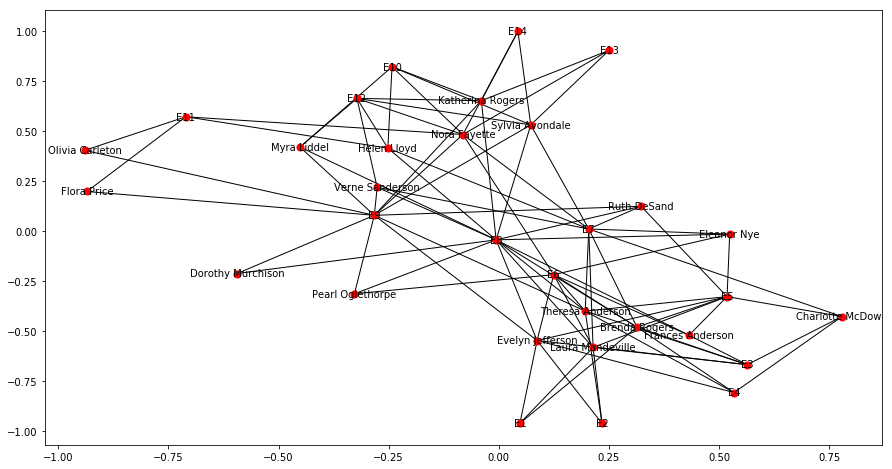

In [8]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random infection

In [9]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [10]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

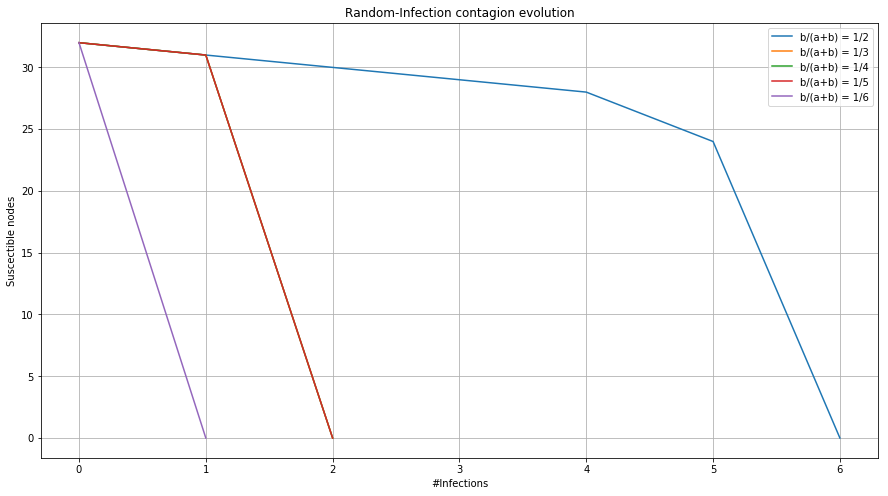

In [11]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [12]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [13]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

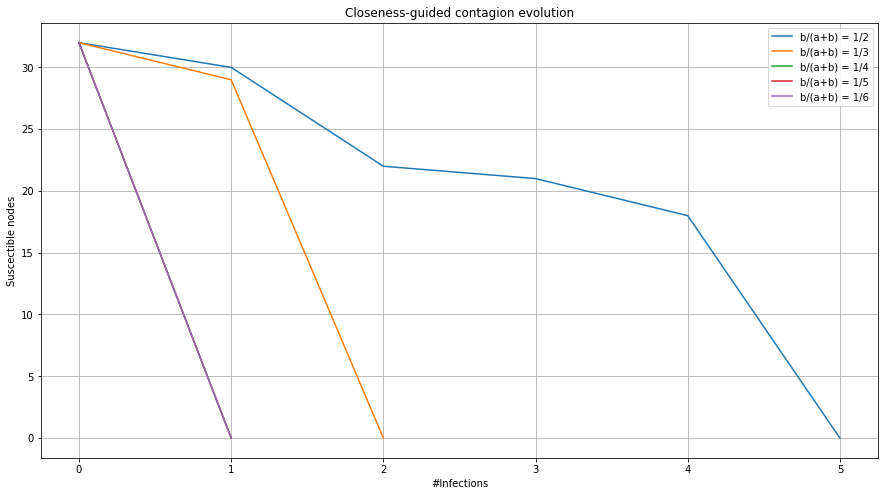

In [14]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [15]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [16]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

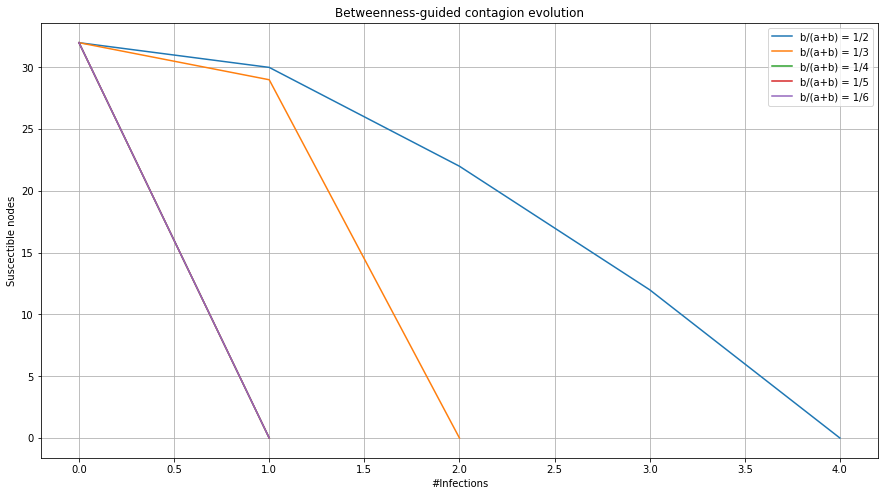

In [17]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [18]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [19]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

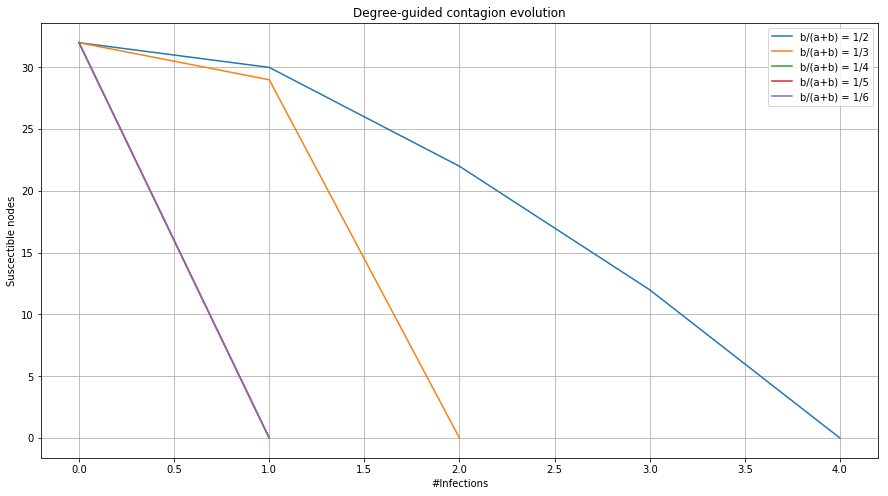

In [20]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [21]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.clustering, G)
#ranked_cls

In [22]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

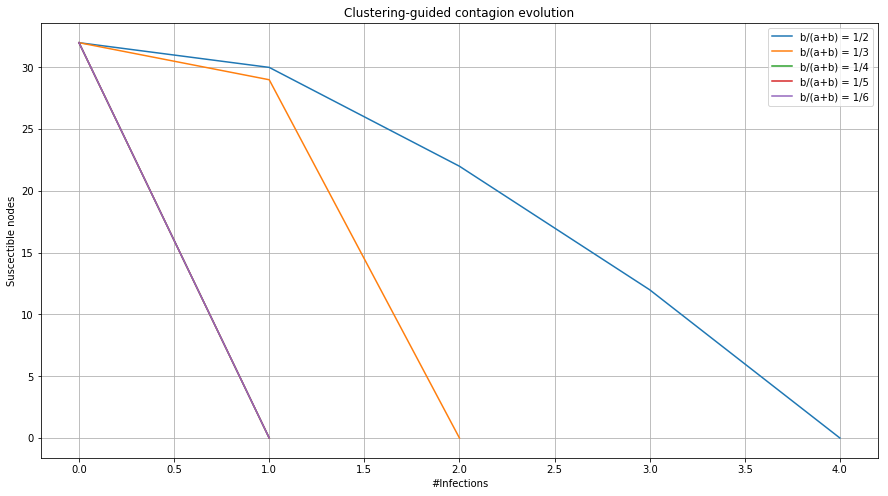

In [23]:
plot_distribution(deg_eval, "Clustering-guided")

### -- pagerank guided infection

In [24]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [25]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

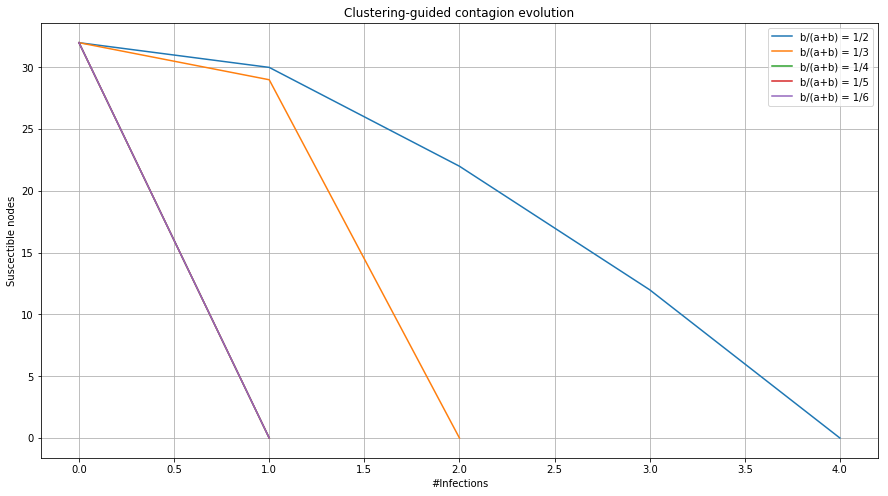

In [26]:
plot_distribution(prk_eval, "Clustering-guided")

### -- HITS (hubs) guided infection

In [27]:
labels = init_labels(G)
ranked_hub = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hub

In [28]:
hub_eval = evaluate_spread(G, payoff_dict, ranked_hub)

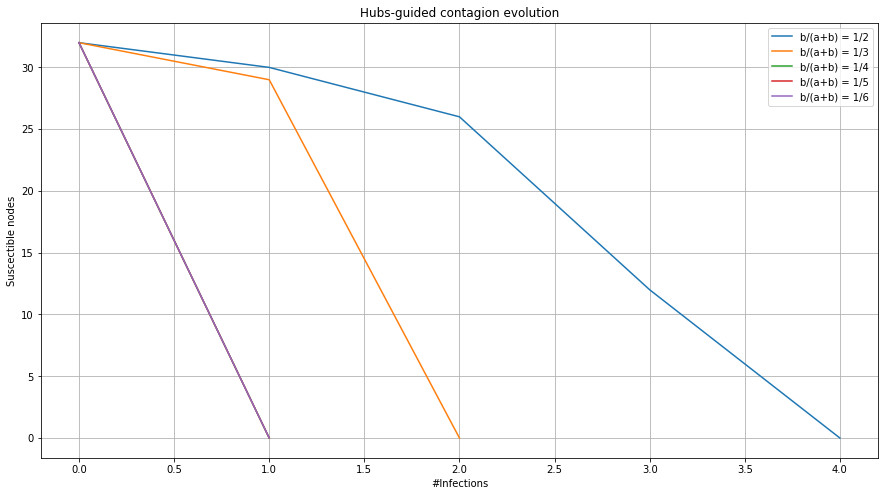

In [29]:
plot_distribution(hub_eval, "Hubs-guided")

### -- HITS (authorities) guided infection

In [30]:
labels = init_labels(G)
ranked_aut = metric_ranking(nx.hits_numpy, G, index=1)
#ranked_aut

In [31]:
aut_eval = evaluate_spread(G, payoff_dict, ranked_aut)

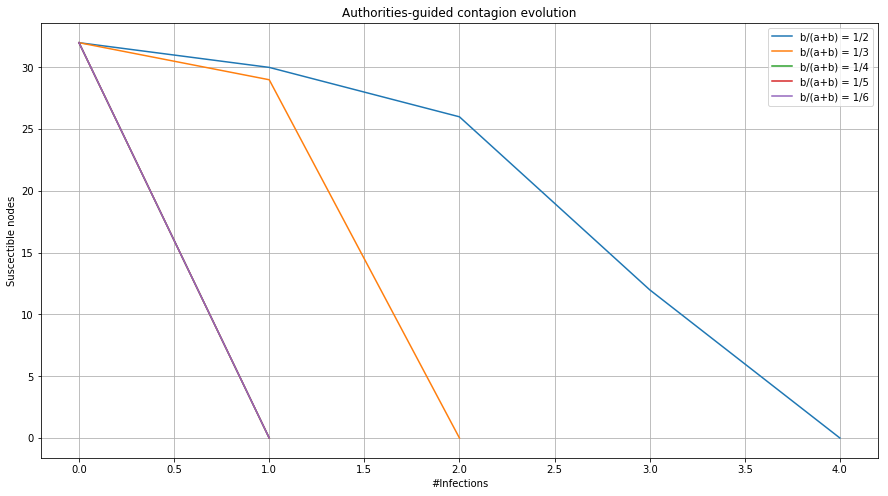

In [32]:
plot_distribution(hub_eval, "Authorities-guided")

## 2. Erdős-Rényi random graph

In [33]:
n = 100

### 2.1  $p<\frac{1}{n}$

In [34]:
G = nx.gnp_random_graph(n,1/(n*2))
pos = nx.spring_layout(G)
print("Average degree = {}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

Average degree = 0.36


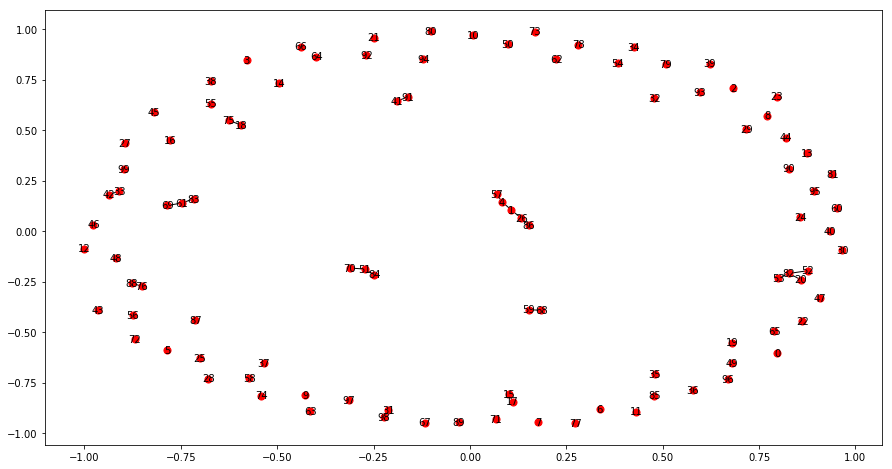

In [35]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [36]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [37]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

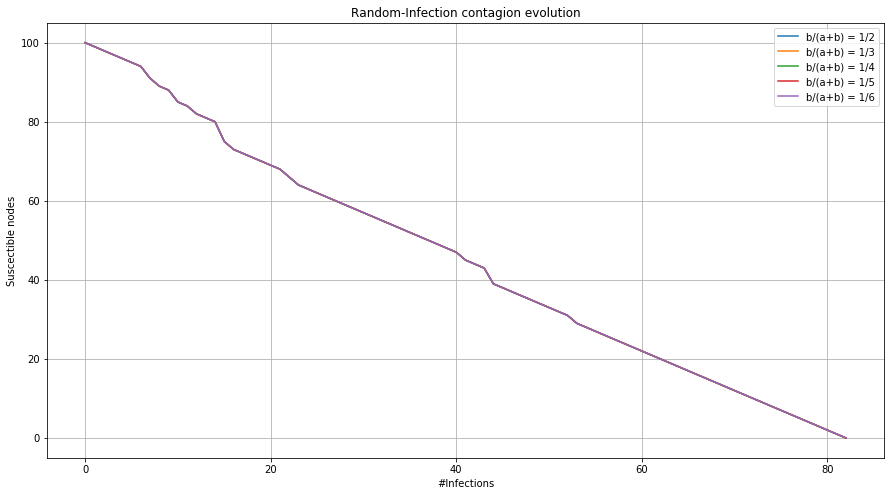

In [38]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [39]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [40]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

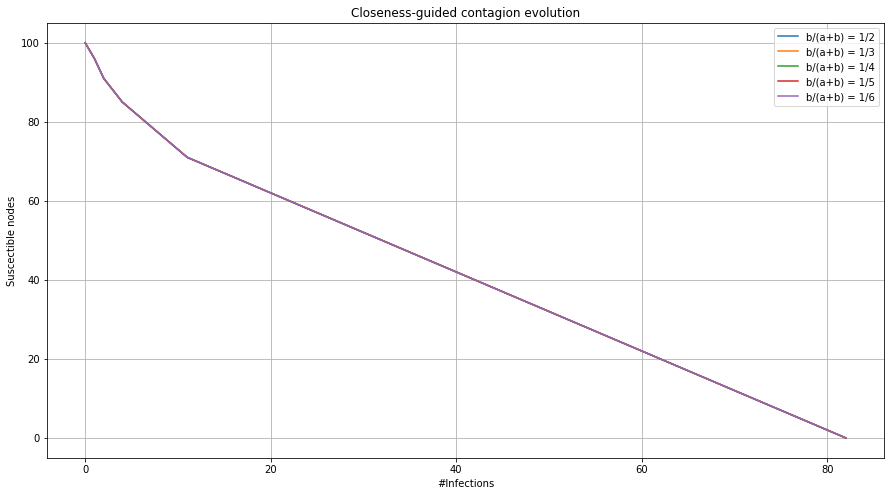

In [41]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [42]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [43]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

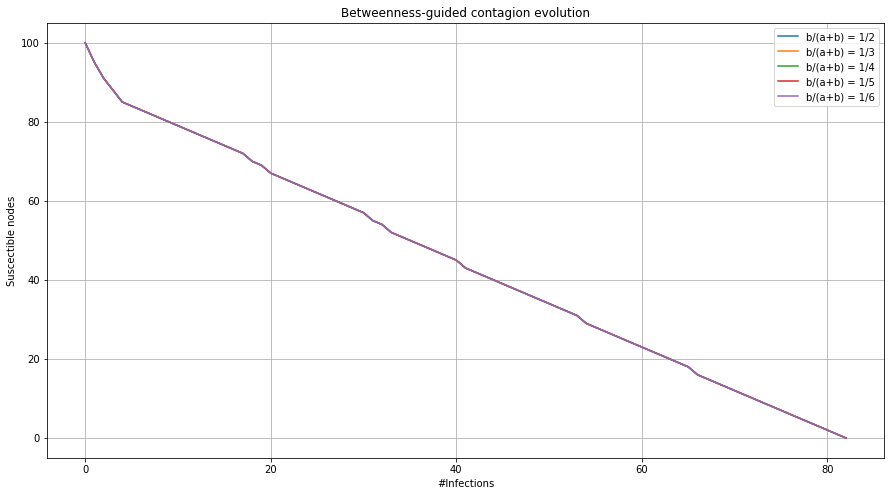

In [44]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [45]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [46]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

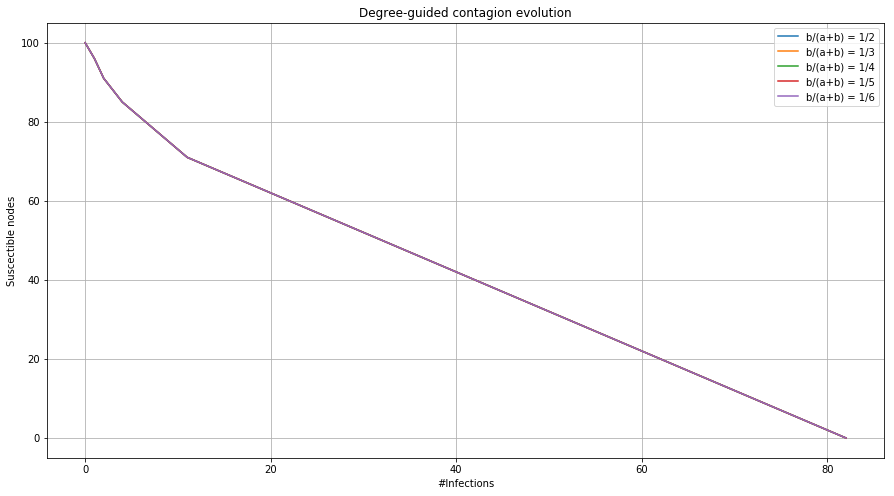

In [47]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [48]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.clustering, G)
#ranked_cls

In [49]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

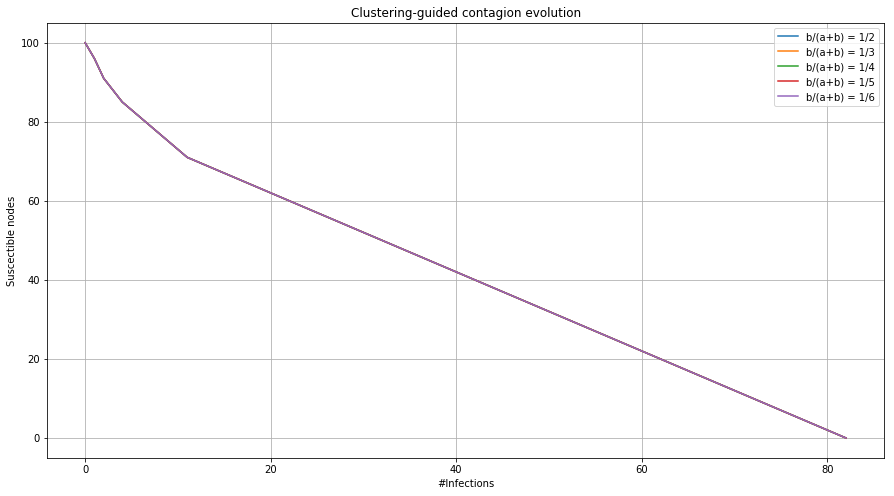

In [50]:
plot_distribution(deg_eval, "Clustering-guided")

### -- pagerank guided infection

In [51]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [52]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

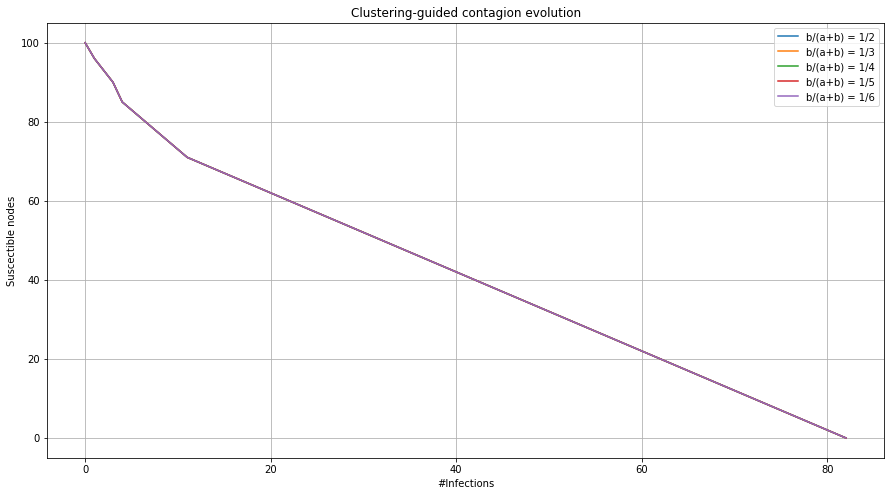

In [53]:
plot_distribution(prk_eval, "Clustering-guided")

### -- HITS (hubs) guided infection

In [54]:
labels = init_labels(G)
ranked_hub = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hub

In [55]:
hub_eval = evaluate_spread(G, payoff_dict, ranked_hub)

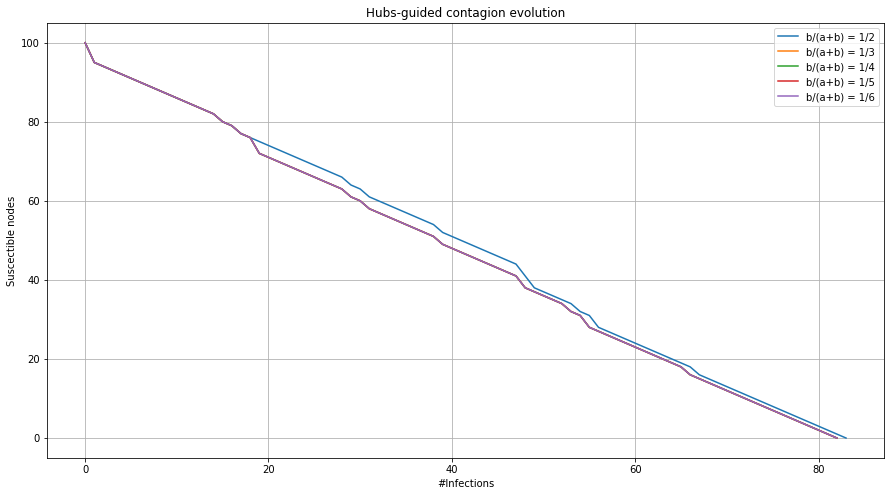

In [56]:
plot_distribution(hub_eval, "Hubs-guided")

### -- HITS (authorities) guided infection

In [57]:
labels = init_labels(G)
ranked_aut = metric_ranking(nx.hits_numpy, G, index=1)
#ranked_aut

In [58]:
aut_eval = evaluate_spread(G, payoff_dict, ranked_aut)

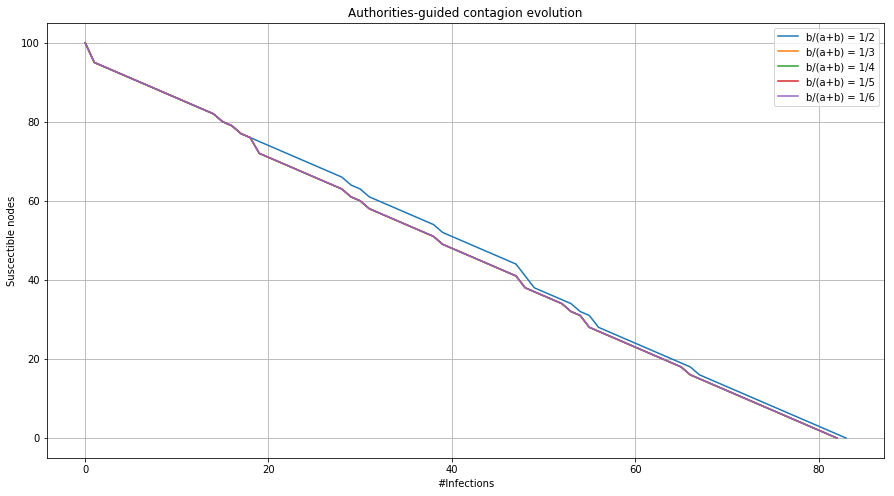

In [59]:
plot_distribution(hub_eval, "Authorities-guided")

### 2.2  $\frac{1}{n}<p<\frac{\log{n}}{n}$

In [60]:
G = nx.gnp_random_graph(n,1/n)
pos = nx.spring_layout(G)
print("Average degree = {}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

Average degree = 0.9


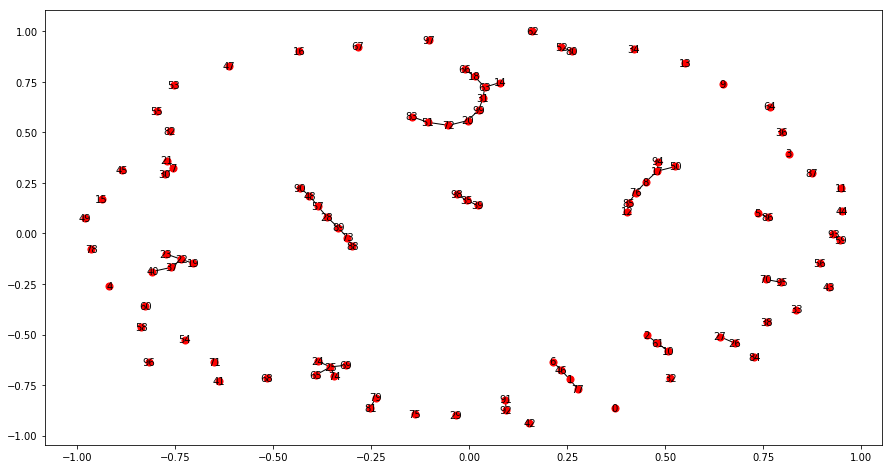

In [61]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [62]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [63]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

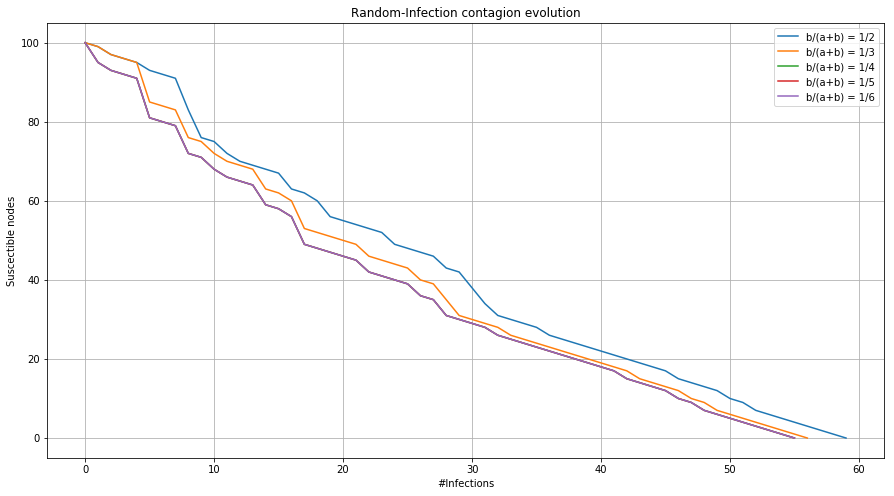

In [64]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [65]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [66]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

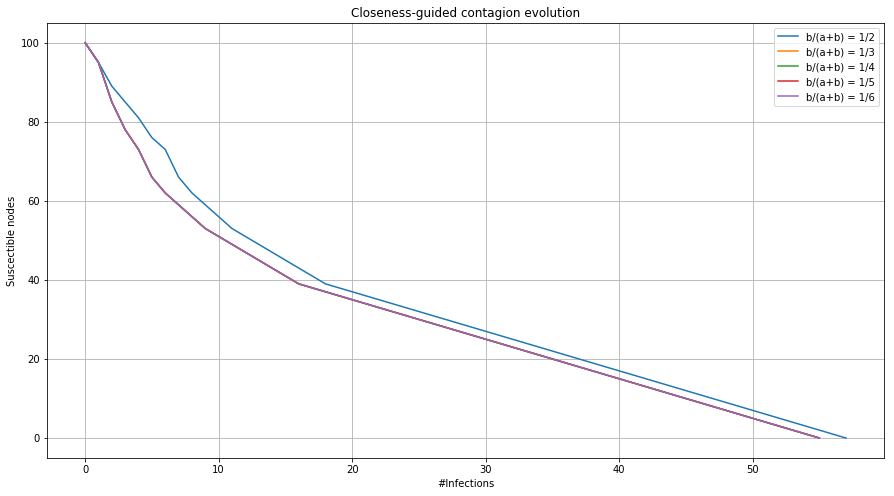

In [67]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [68]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [69]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

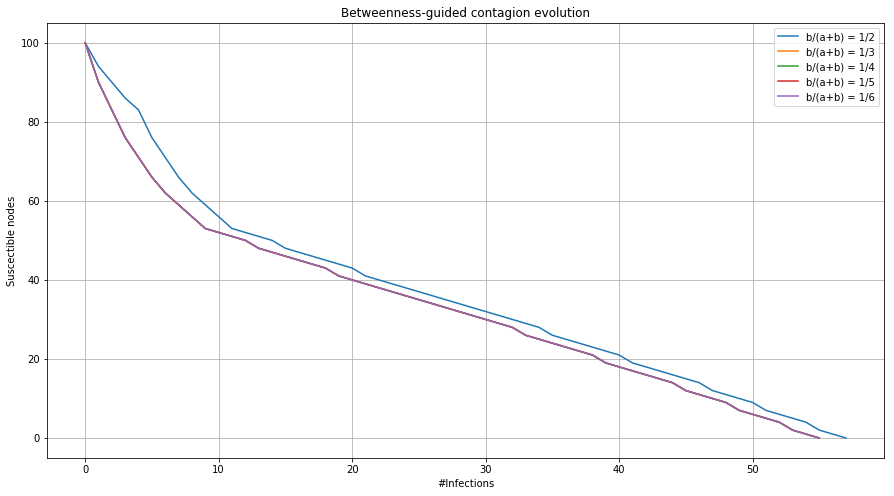

In [70]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [71]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [72]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

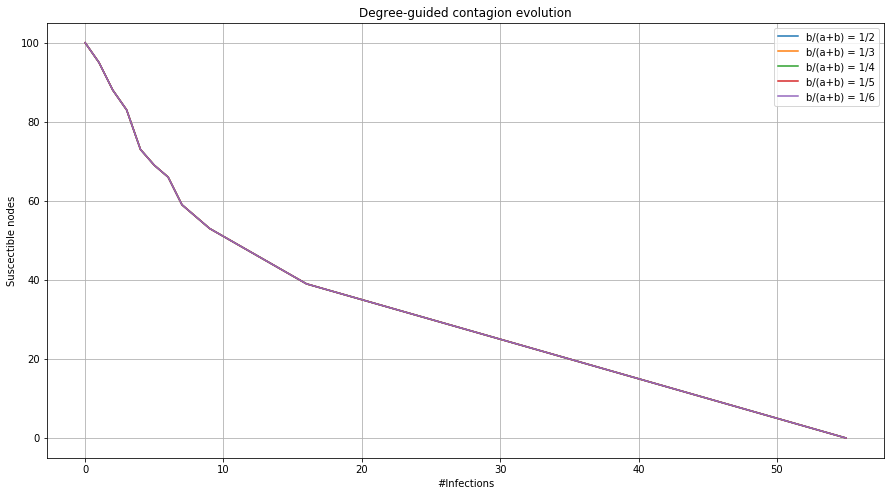

In [73]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [74]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.clustering, G)
#ranked_cls

In [75]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

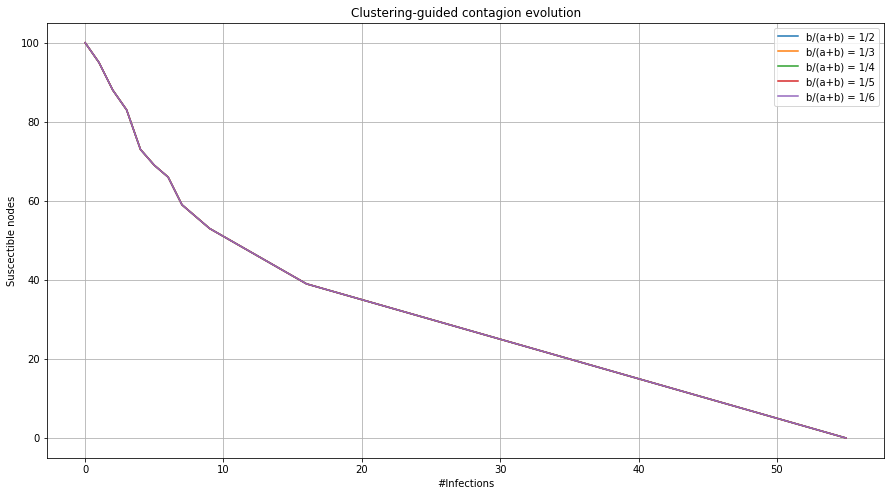

In [76]:
plot_distribution(deg_eval, "Clustering-guided")

### -- pagerank guided infection

In [77]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [78]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

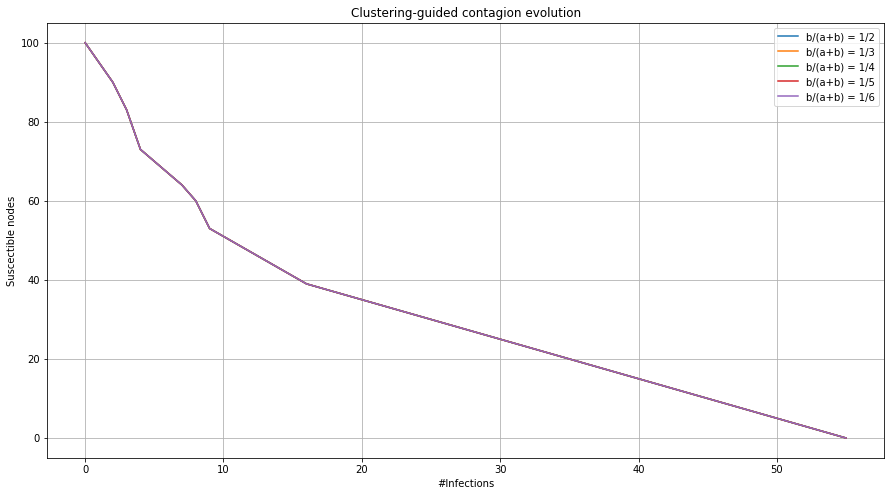

In [79]:
plot_distribution(prk_eval, "Clustering-guided")

### -- HITS (hubs) guided infection

In [86]:
labels = init_labels(G)
ranked_hub = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hub

In [87]:
hub_eval = evaluate_spread(G, payoff_dict, ranked_hub)

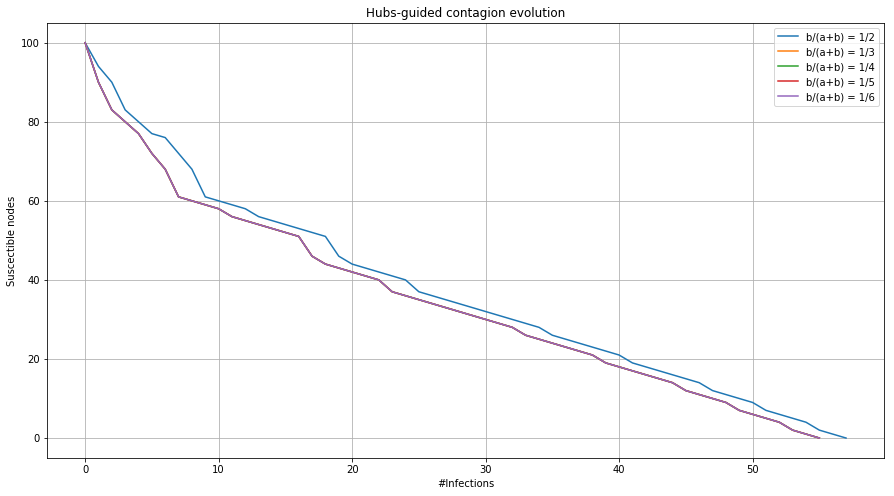

In [88]:
plot_distribution(hub_eval, "Hubs-guided")

### -- HITS (authorities) guided infection

In [89]:
labels = init_labels(G)
ranked_aut = metric_ranking(nx.hits_numpy, G, index=1)
#ranked_aut

In [90]:
aut_eval = evaluate_spread(G, payoff_dict, ranked_aut)

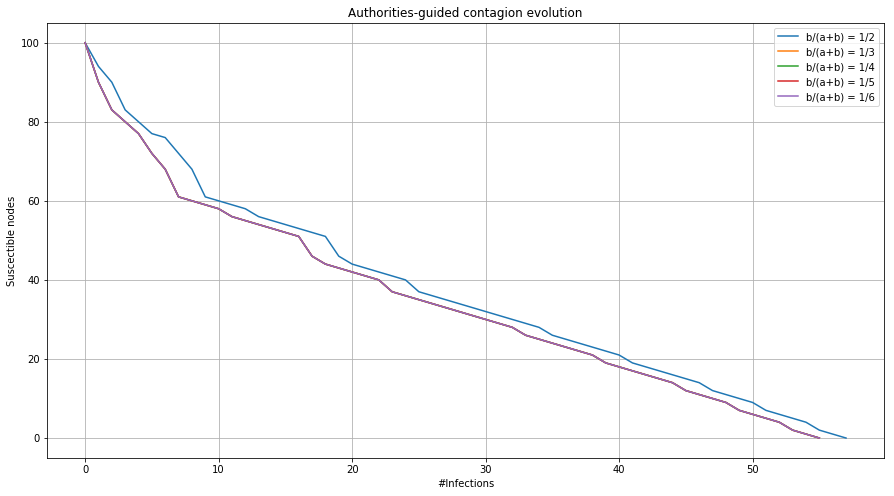

In [91]:
plot_distribution(hub_eval, "Authorities-guided")

### 2.3  $p>\frac{\log{n}}{n}$

In [92]:
G = nx.gnp_random_graph(n,np.log(n*2)/n)
pos = nx.spring_layout(G)
print("log(n)={}, <k>={}".format(round(np.log(100),2), np.mean(list(map(lambda item:item[1], G.degree)))))

log(n)=4.61, <k>=4.78


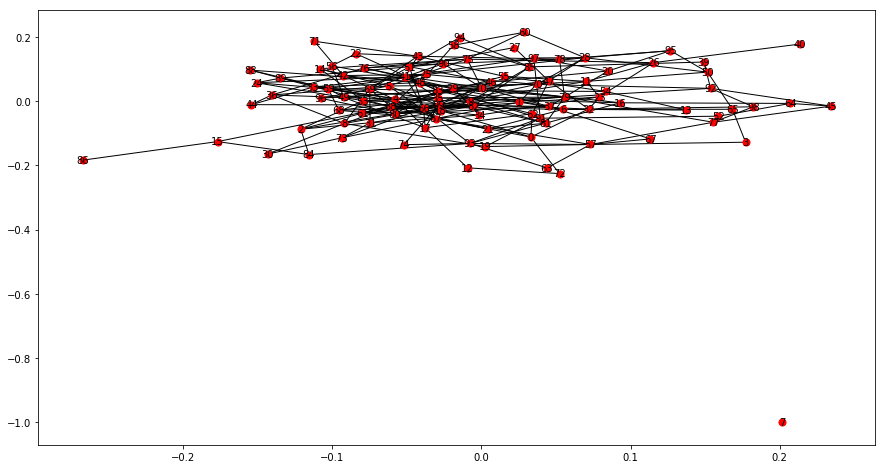

In [93]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [94]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [95]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

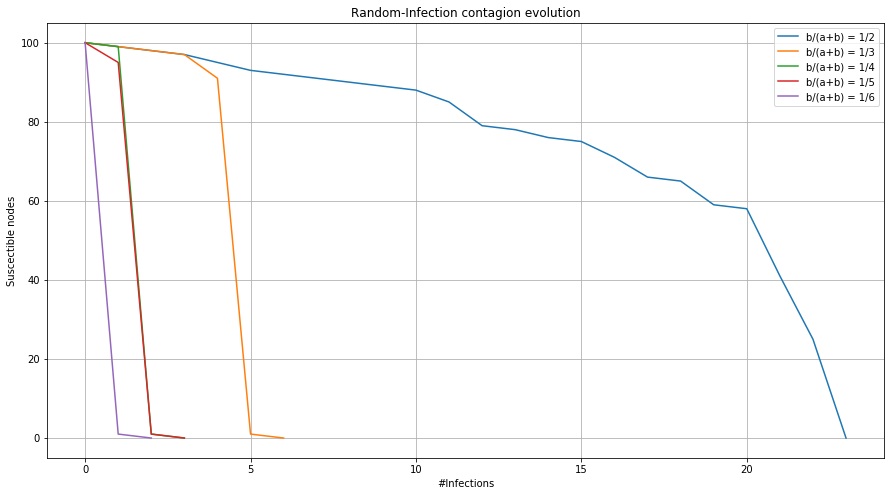

In [96]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [97]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [98]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

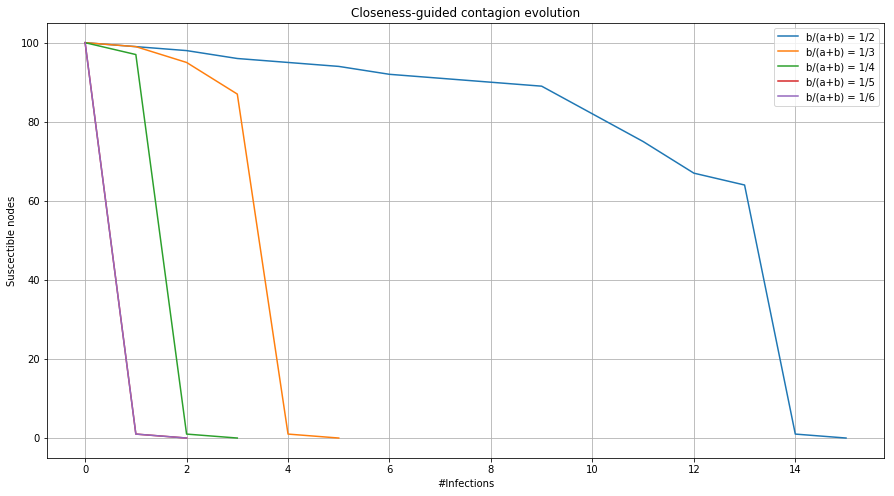

In [99]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [100]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [101]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

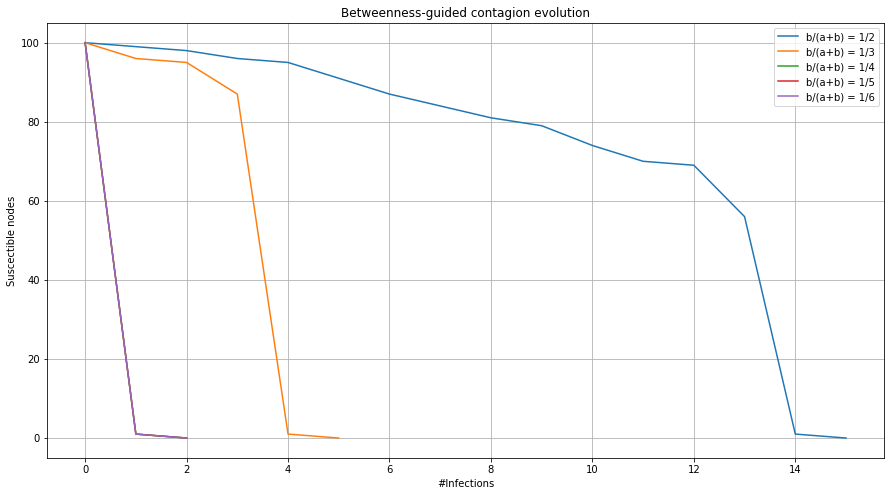

In [102]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [103]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [104]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

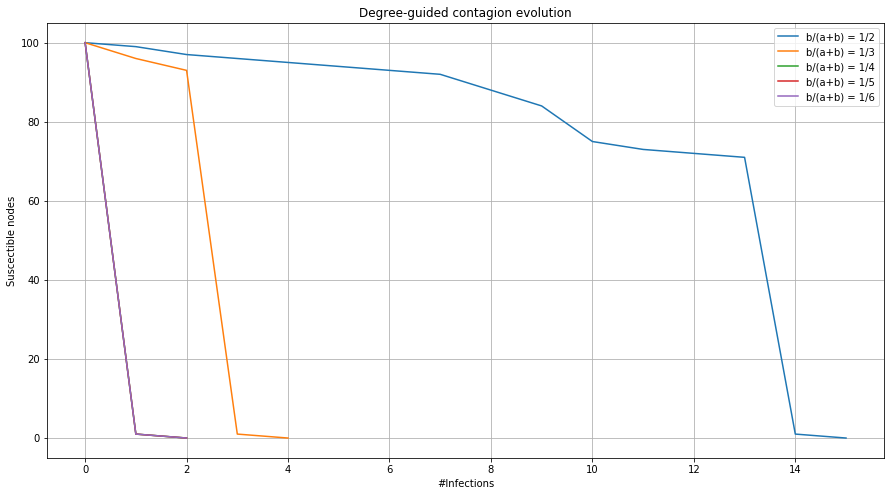

In [105]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [106]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.clustering, G)
#ranked_cls

In [107]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

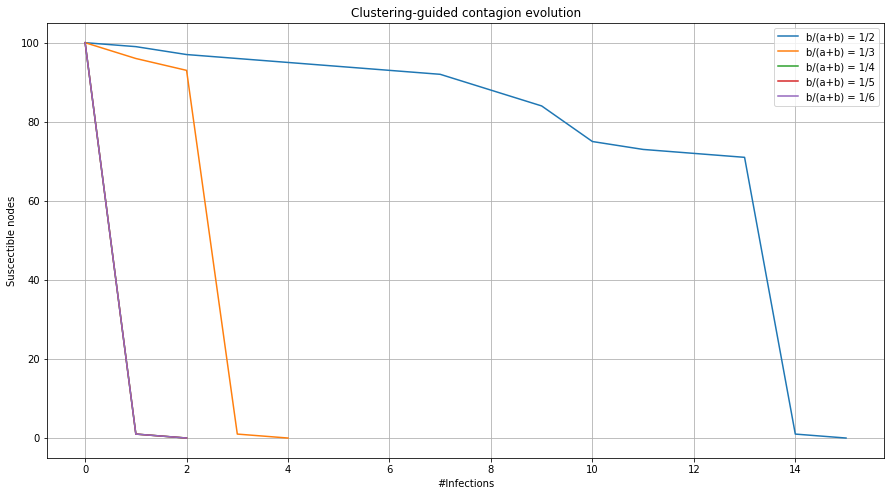

In [108]:
plot_distribution(deg_eval, "Clustering-guided")

### -- pagerank guided infection

In [109]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [110]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

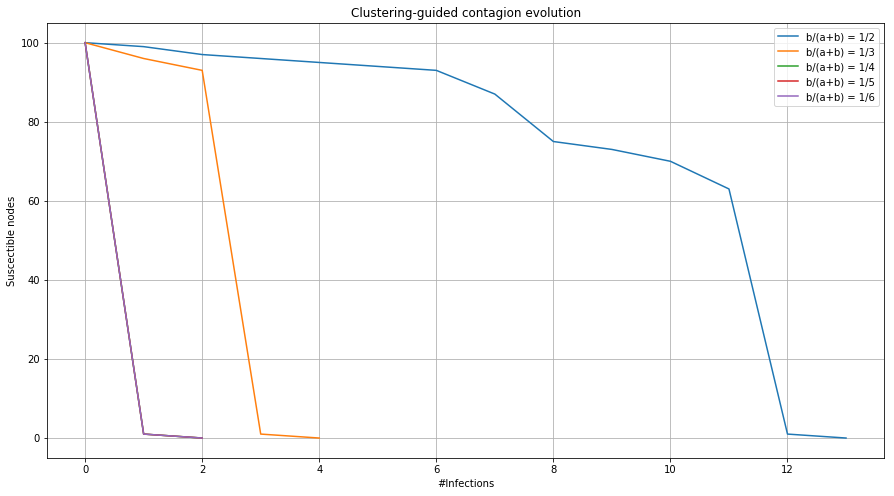

In [111]:
plot_distribution(prk_eval, "Clustering-guided")

### -- HITS (hubs) guided infection

In [112]:
labels = init_labels(G)
ranked_hub = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hub

In [113]:
hub_eval = evaluate_spread(G, payoff_dict, ranked_hub)

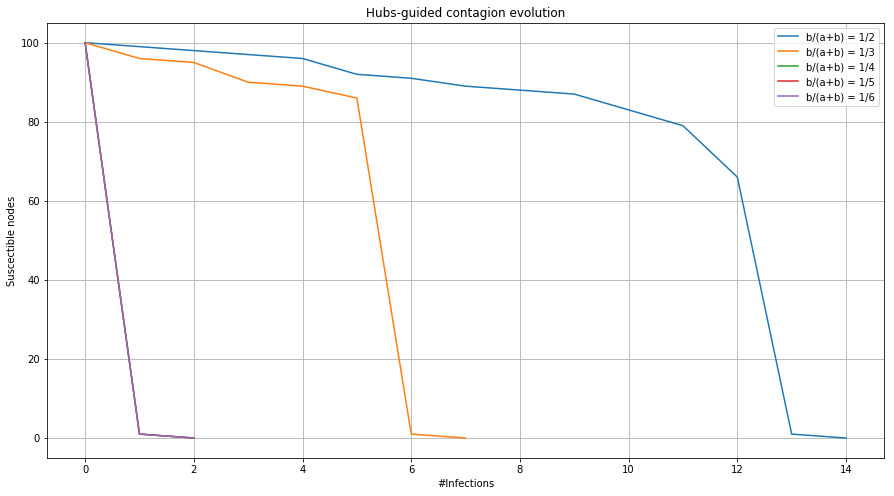

In [114]:
plot_distribution(hub_eval, "Hubs-guided")

### -- HITS (authorities) guided infection

In [115]:
labels = init_labels(G)
ranked_aut = metric_ranking(nx.hits_numpy, G, index=1)
#ranked_aut

In [116]:
aut_eval = evaluate_spread(G, payoff_dict, ranked_aut)

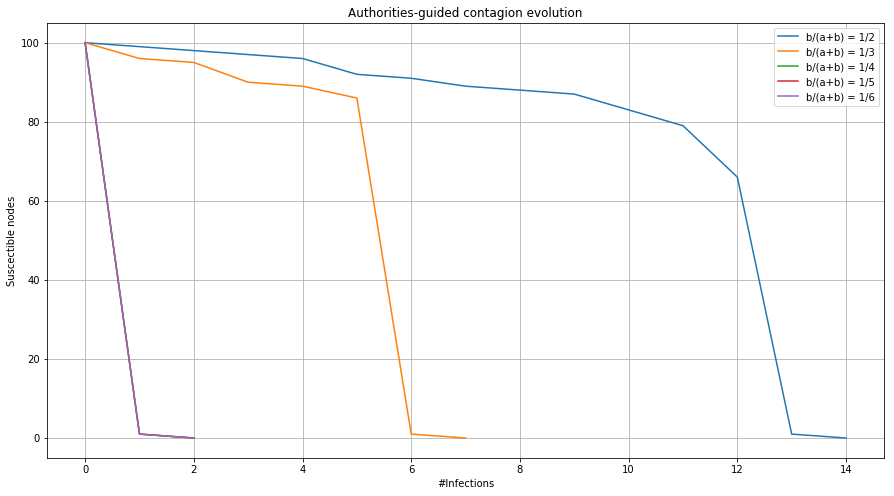

In [117]:
plot_distribution(hub_eval, "Authorities-guided")

## 3. Power law network

In [118]:
G = nx.powerlaw_cluster_graph(n,1,0.5)
pos = nx.spring_layout(G)

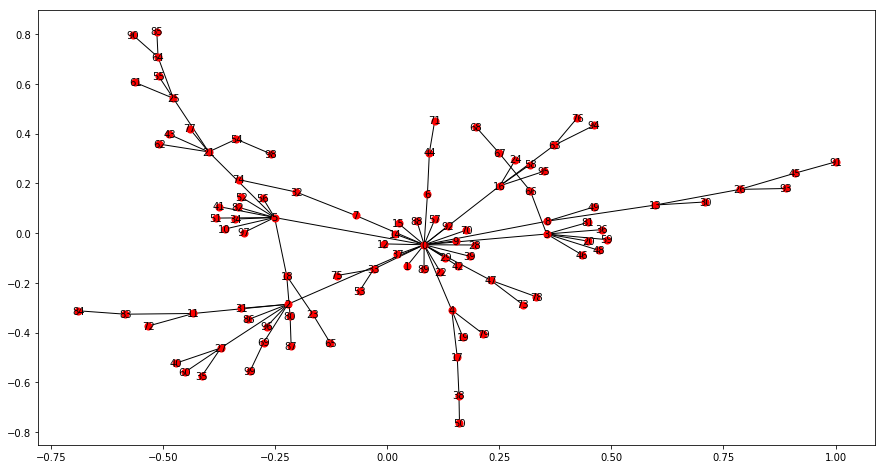

In [119]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random infection

In [120]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [121]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

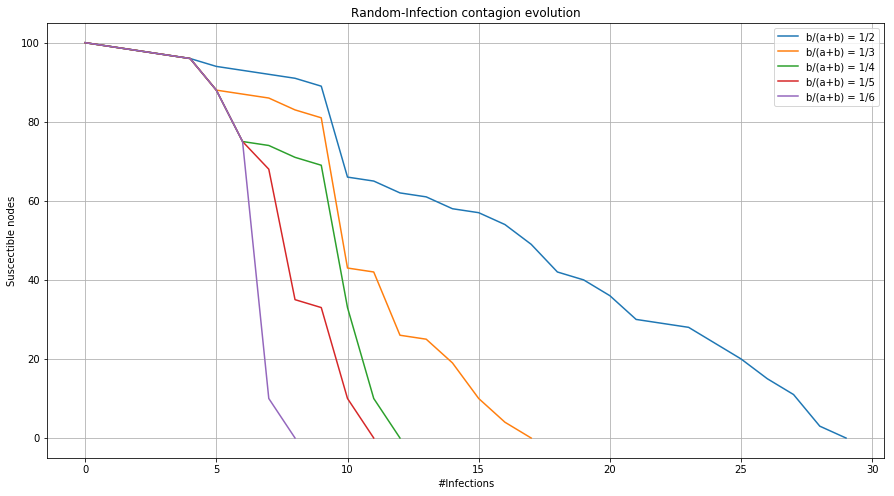

In [122]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [123]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [124]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

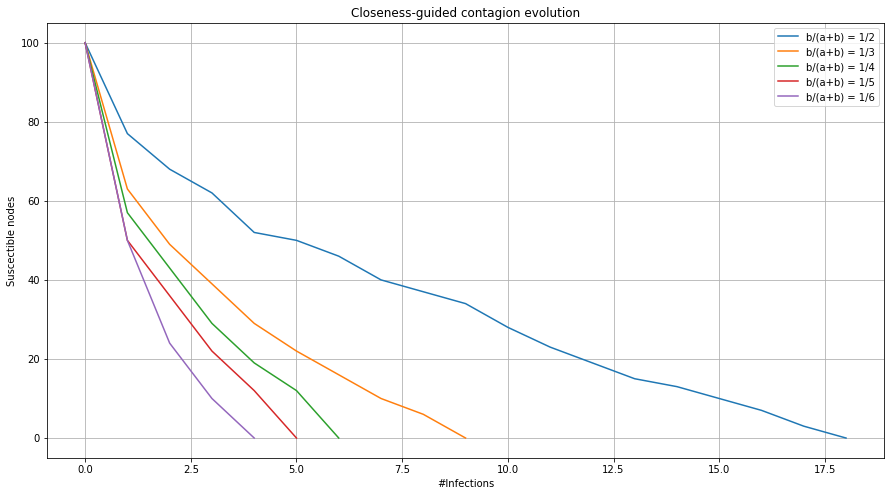

In [125]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [126]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [127]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

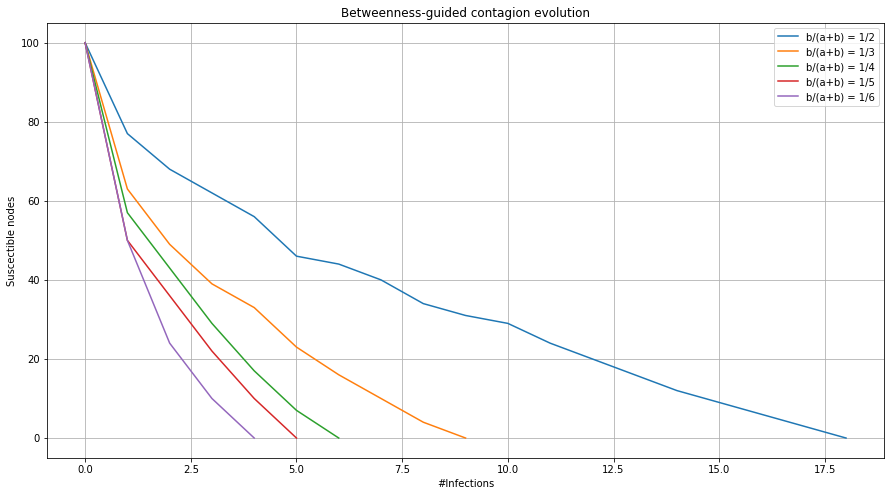

In [128]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [129]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [130]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

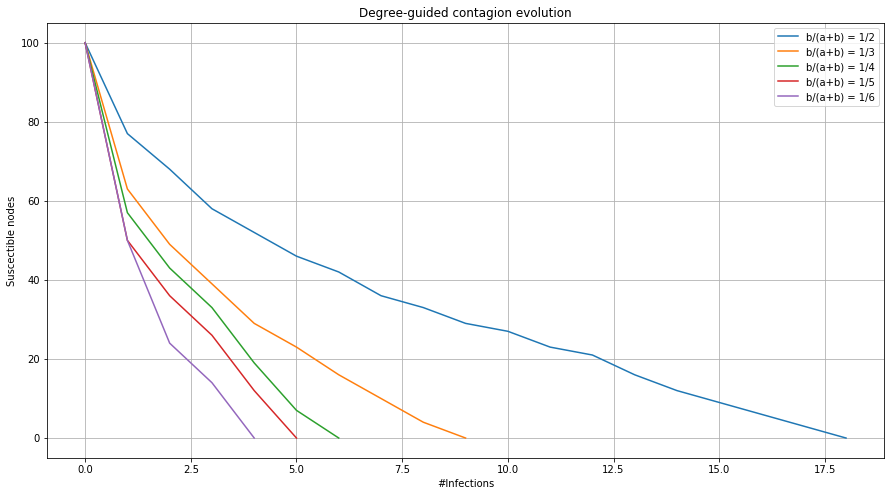

In [131]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [132]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.clustering, G)
#ranked_cls

In [133]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

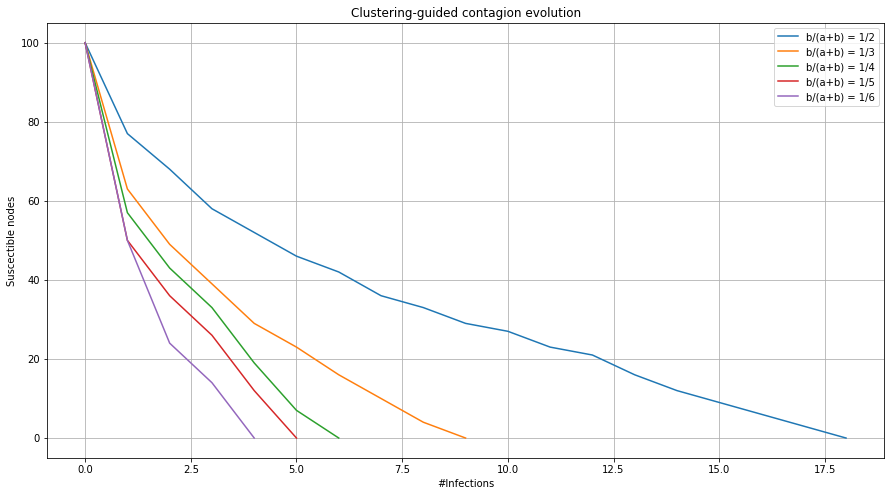

In [134]:
plot_distribution(deg_eval, "Clustering-guided")

### -- pagerank guided infection

In [135]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [136]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

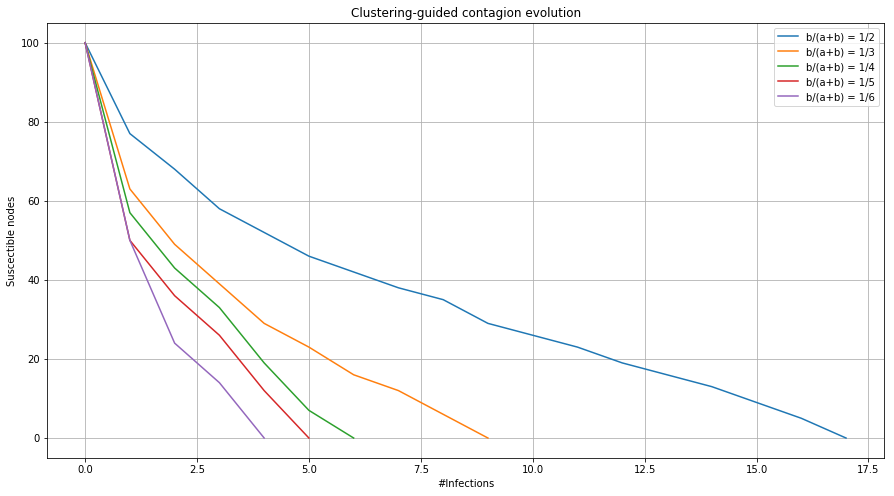

In [137]:
plot_distribution(prk_eval, "Clustering-guided")

### -- HITS (hubs) guided infection

In [138]:
labels = init_labels(G)
ranked_hub = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hub

In [139]:
hub_eval = evaluate_spread(G, payoff_dict, ranked_hub)

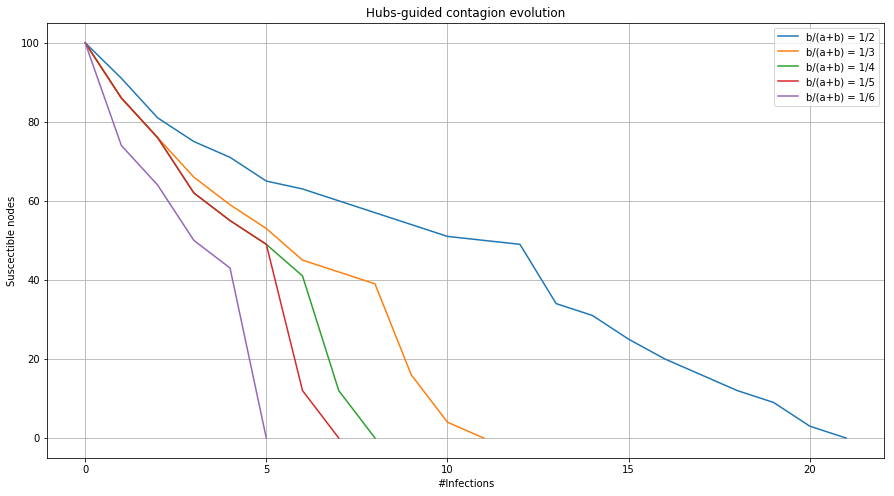

In [140]:
plot_distribution(hub_eval, "Hubs-guided")

### -- HITS (authorities) guided infection

In [141]:
labels = init_labels(G)
ranked_aut = metric_ranking(nx.hits_numpy, G, index=1)
#ranked_aut

In [142]:
aut_eval = evaluate_spread(G, payoff_dict, ranked_aut)

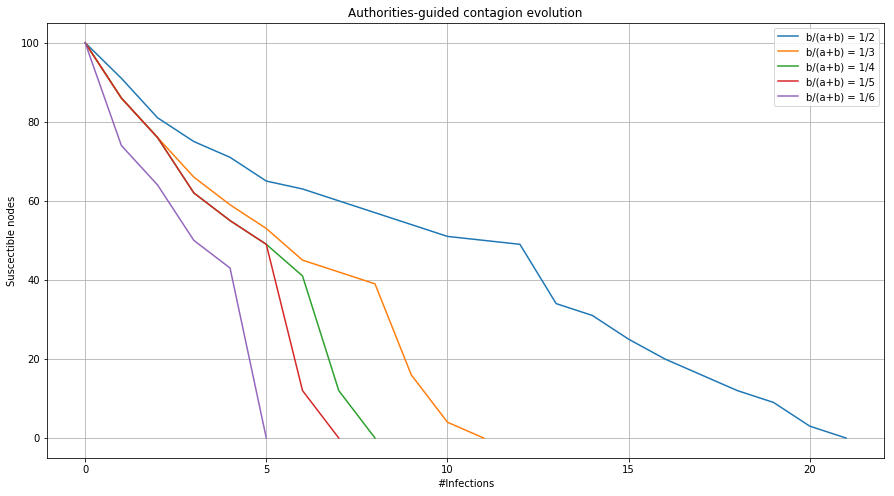

In [143]:
plot_distribution(hub_eval, "Authorities-guided")

## 4. Real Graph - arXiv citations

In [ ]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G, posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random infection

In [ ]:
labels = init_labels(G)
rankedInfection = random_ranking(G)
#rankedInfection

In [ ]:
rand_eval = evaluate_spread(G, payoff_dict, rankedInfection)

In [ ]:
plot_distribution(rand_eval, "Random-Infection")

### -- closeness guided infection

In [ ]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.closeness_centrality, G)
#ranked_cls

In [ ]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [ ]:
plot_distribution(cls_eval, "Closeness-guided")

### -- betweenness guided infection

In [ ]:
labels = init_labels(G)
ranked_btw = metric_ranking(nx.betweenness_centrality, G)
#ranked_btw

In [ ]:
btw_eval = evaluate_spread(G, payoff_dict, ranked_btw)

In [ ]:
plot_distribution(btw_eval, "Betweenness-guided")

### -- highest degree guided infection

In [ ]:
labels = init_labels(G)
ranked_deg = metric_ranking(nx.degree, G)
#ranked_deg

In [ ]:
deg_eval = evaluate_spread(G, payoff_dict, ranked_deg)

In [ ]:
plot_distribution(deg_eval, "Degree-guided")

### -- clustering guided infection

In [ ]:
labels = init_labels(G)
ranked_cls = metric_ranking(nx.clustering, G)
#ranked_cls

In [ ]:
cls_eval = evaluate_spread(G, payoff_dict, ranked_cls)

In [ ]:
plot_distribution(deg_eval, "Clustering-guided")

### -- pagerank guided infection

In [ ]:
labels = init_labels(G)
ranked_prk = metric_ranking(nx.pagerank_numpy, G)
#ranked_prk

In [ ]:
prk_eval = evaluate_spread(G, payoff_dict, ranked_prk)

In [ ]:
plot_distribution(prk_eval, "Clustering-guided")

### -- HITS (hubs) guided infection

In [ ]:
labels = init_labels(G)
ranked_hub = metric_ranking(nx.hits_numpy, G, index=0)
#ranked_hub

In [ ]:
hub_eval = evaluate_spread(G, payoff_dict, ranked_hub)

In [ ]:
plot_distribution(hub_eval, "Hubs-guided")

### -- HITS (authorities) guided infection

In [ ]:
labels = init_labels(G)
ranked_aut = metric_ranking(nx.hits_numpy, G, index=1)
#ranked_aut

In [ ]:
aut_eval = evaluate_spread(G, payoff_dict, ranked_aut)

In [ ]:
plot_distribution(hub_eval, "Authorities-guided")